In [1]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ArtistAnimation, PillowWriter
from IPython.display import HTML
import random as rn
import numpy as np
import pandas as pd
from numpy.random import choice as np_choice

In [2]:
# Algoritmo colonia de hormigas en Python
# Implementación adaptada del algoritmo desarrollado por Kirill Temlyakov (https://github.com/Akavall)
# y disponible en el repositorio: https://github.com/Akavall/AntColonyOptimization

class AntColony(object):

    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1

        Example:
            ant_colony = AntColony(german_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
        """
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.iterations = []
        self.best_route = []

    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            #print (shortest_path)
            self.iterations.append(shortest_path)
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path            
            self.pheromone = self.pheromone * self.decay
        self.best_route = self.get_list(all_time_shortest_path[0])
        return all_time_shortest_path

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started    
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move

    def get_list(self, shortest_path_full):
        self.best_route = []
        for item in shortest_path_full:
            self.best_route.append(item[0])
        self.best_route.append(shortest_path_full[0][0])
        return self.best_route
        

In [3]:

# Cargar datos
data = pd.read_csv('matriz_costos.csv')  # Archivo CSV con las coordenadas de las ciudades
data.drop(columns=data.columns[0])
cities = data.values[:,1:]
np.fill_diagonal(cities, np.inf)
cities = cities.astype(float)

ant_colony = AntColony(cities, 1, 1, 100, 0.95, alpha=1, beta=1)
shortest_path = ant_colony.run()
print("Mejor ruta calculada:", ant_colony.get_list(shortest_path[0]))
print("Costo: $",shortest_path[1])

Mejor ruta calculada: [0, 1, 4, 6, 10, 9, 11, 8, 7, 14, 13, 3, 12, 2, 5, 0]
Costo: $ 3947463.0


## Viualización del cálculo de la mejor ruta con 100 iteraciones

['Palmira', 'Pasto', 'Tuluá', 'Bogota', 'Pereira', 'Armenia', 'Manizales', 'Valledupar', 'Montería', 'Soledad Atlantico', 'Cartagena de indias', 'Barranquilla', 'Medellín', 'Bucaramanga', 'Cúcuta']


C:\Users\dgilr\AppData\Local\Temp\ipykernel_21440\1259338917.py:20: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  colombia = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


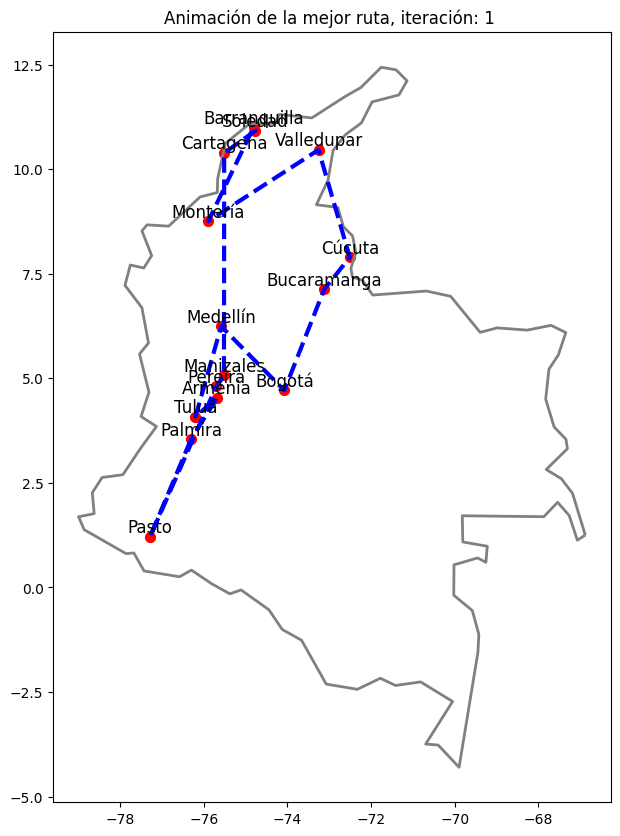

In [5]:

cities_labels = data.values[:,0].tolist()
print(cities_labels)

# Crear un dataframe con las ciudades y sus coordenadas
ciudades = {
    'Ciudad': ['Palmira', 'Pasto', 'Tuluá', 'Bogotá', 'Pereira', 'Armenia', 'Manizales', 'Valledupar',
               'Montería', 'Soledad', 'Cartagena', 'Barranquilla', 'Medellín', 'Bucaramanga', 'Cúcuta'],
    'Latitud': [3.5391, 1.2136, 4.0847, 4.7110, 4.8133, 4.5339, 5.0687, 10.4631, 8.7575, 10.9184, 10.3910, 11.0041, 6.2442, 7.1254, 7.8938],
    'Longitud': [-76.3036, -77.2811, -76.1953, -74.0721, -75.6961, -75.6811, -75.5144, -73.2538, -75.8899, -74.7623, -75.5090, -74.8060, -75.5812, -73.1198, -72.5071]
}
df = gpd.GeoDataFrame(ciudades, geometry=gpd.points_from_xy(ciudades['Longitud'], ciudades['Latitud']))
# Crear una línea que pase por todas las ciudades en el orden de la mejor ruta
coordenadas = []
for city in ant_colony.best_route:
  coordenadas.append((ciudades['Longitud'][city],ciudades['Latitud'][city]))
ruta = LineString(coordenadas)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 10))
colombia = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
colombia = colombia[colombia.name == 'Colombia']
colombia.boundary.plot(ax=ax, linewidth=2, color='gray')

# Agregar puntos de ciudades con etiquetas de texto
labels = []
for idx, row in df.iterrows():
    label = ax.text(row['Longitud'], row['Latitud'], row['Ciudad'], fontsize=12, ha='center', va='bottom')
    labels.append(label)

df.plot(ax=ax, marker='o', color='red', markersize=50, label='Ciudades')

# Función de animación
def animate(i):
    if i > 1:
        segment = LineString(list(ruta.coords)[:i])
        ax.clear()
        colombia.boundary.plot(ax=ax, linewidth=2, color='gray')
        df.plot(ax=ax, marker='o', color='red', markersize=50, label='Ciudades')
        gpd.GeoSeries([segment]).plot(ax=ax, color='blue', linewidth=3, linestyle='--', label='Ruta')
        ax.set_title(f'Animación de la mejor ruta, iteración: {1} ')
        # Agregar etiquetas de texto con el nombre de las ciudades
        for idx, row in df.iterrows():
            ax.text(row['Longitud'], row['Latitud'], row['Ciudad'], fontsize=12, ha='center', va='bottom')

# Crear la animación
frames = len(list(ruta.coords)) + 1
anim = FuncAnimation(fig, animate, frames=frames, interval=500, repeat=False)

# Mostrar la animación en formato HTML
anim.save('ruta_colonia_hormigas.gif', writer='pillow', fps=1)